# Preparing VanZyl-1 Data for Analysis

This guide shows how to access and prepare different VZ-1 imagery products for further analysis. We explore topics such as deriving brightness temperature from the Level-1 data and calculating NDVI from Level-2 surface reflectance.

## 1. Accessing Hydrosat's STAC API

We'll start by connecting to the STAC API and querying data from a specific area of interest (AOI) and time period of interest (TOI). See the ```vz-quickstart``` or ```searching-the-catalog``` guides for more detailed explanations of these steps.

### 1.1 Import dependencies

In [199]:
import json
import requests
import pystac
from pystac_client import Client
import base64

### 1.2 Authenticate and connect to the STAC API

To run the next cell, you should have set up a `creds.json` file containing your username and password in the same directory as this notebook.

In [200]:
with open('creds.json') as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://stac.hydrosat.com/'
catalog = Client.open(cat_url, headers)

## 2. Level-1 Data Products

We'll start by exploring some lower-level VZ-1 imagery. In particular, we'll show how the user can derive brightness temperature from Level-1 radiance data.

### 2.1 Calculating brightness temperature (BT) from the L1B data

Let's start by looking for data in the ```vz-l1b``` collection that intersects a specific AOI and TOI. Each Level-1B item contains assets representing top-of-atmosphere radiance from 7 VNIR and 2 LWIR spectral bands at 30 m spatial resolution.

Level-1A items also contain radiance data, but VNIR and LWIR data are stored separately and delivered at the native resolution of each imager. That is, ~30 m VNIR data is provided in the ```vz-viri-l1a``` collection and ~70 m LWIR data is available in the ```vz-liri-l1a``` collection.

In [201]:
collection_id = 'vz-l1b'

In [202]:
bbox = [-91.35, 37.11, -88.04, 39.78] # Bounding box to search within [left, bottom, right, top]

In [203]:
# Start and end dates for the query
start_date = "2025-04-15"
start_time = "T00:00:00Z"

end_date = "2025-07-15"
end_time = "T00:00:00Z"
datetime_range = [start_date+start_time, end_date+end_time]

#### 2.1.1 Searching the catalog

In [204]:
search = catalog.search(
        collections = collection_id,
        bbox = bbox,
        datetime = datetime_range
    )

l1b_items = list(search.items())
l1b_items.reverse() # Oldest to newest

print(f"Found {len(l1b_items)} items.\n")
print("Item IDs:")
for i, item in enumerate(l1b_items):
    print(f"{i+1}. {item.id}")

Found 1 items.

Item IDs:
1. VZ01_L1b_20250507_170559


Here, we'll convert the L1B data from digital numbers (DNs) to brightness temperature.

We'll focus on a specific item, defined by ```item_idx```, in this example.

In [205]:
item_idx = 0
l1b_item = l1b_items[item_idx]

#### 2.1.2 Accessing the metadata

We'll need to gather some information from the metadata for the brightness temperature conversion.

Let's start by retrieving the metadata JSON from the item of interest.

In [206]:
metadata = requests.get(l1b_item.assets['metadata'].href).json()

Here, we'll look through the file to better understand what it contains.

In [207]:
import pandas as pd
  
for key in metadata.keys():
    print(key+':\n')
    df = pd.DataFrame.from_dict(metadata[key], orient='index')
    print(df.to_string(header=False))
    print("...........\n")

PRODUCT_CONTENTS:

SCENE_ID                              VZ01_L1b_20250507_170559
OUTPUT_FORMAT                          CLOUD OPTIMIZED GEOTIFF
FILE_NAME_LWIR1            VZ01_L1b_20250507_170559_LWIR1.tiff
FILE_NAME_LWIR2            VZ01_L1b_20250507_170559_LWIR2.tiff
FILE_NAME_RED                VZ01_L1b_20250507_170559_RED.tiff
FILE_NAME_GREEN            VZ01_L1b_20250507_170559_GREEN.tiff
FILE_NAME_BLUE              VZ01_L1b_20250507_170559_BLUE.tiff
FILE_NAME_REDEDGE1      VZ01_L1b_20250507_170559_REDEDGE1.tiff
FILE_NAME_REDEDGE2      VZ01_L1b_20250507_170559_REDEDGE2.tiff
FILE_NAME_REDEDGE3      VZ01_L1b_20250507_170559_REDEDGE3.tiff
FILE_NAME_NIR                VZ01_L1b_20250507_170559_NIR.tiff
FILE_NAME_THUMBNAIL     VZ01_L1b_20250507_170559_THUMBNAIL.png
FILE_NAME_PREVIEW        VZ01_L1b_20250507_170559_PREVIEW.tiff
FILE_NAME_QA                  VZ01_L1b_20250507_170559_QA.tiff
FILE_NAME_CLOUD_MASK  VZ01_L1b_20250507_170559_CLOUD_MASK.tiff
VERSION                             

To calculate brightness temperature, we need to retrieve the gain, offset, and thermal constants from the metadata.

In [208]:
asset = 'LWIR1'

# Make sure the asset of interest is in the item
assert asset in item.assets.keys()

# Retrieve gain and offset values for the band of interest from the metadata
gain, offset = [value for key, value in metadata['LEVEL1_RADIOMETRIC_RESCALING'].items() if ('RADIANCE' in key) and (asset in key)]

# Retrieve thermal constants from the metadata
K1, K2 = [value for key, value in metadata['LEVEL1_THERMAL_CONSTANTS'].items() if asset in key]

#### 2.1.3 Converting DNs to radiance, and radiance to BT

Let's retrieve the LWIR data from the STAC item.

In [209]:
import rioxarray as rxr
import numpy as np

# Access the LWIR1 data using rioxarray
lwir = rxr.open_rasterio(item.assets[asset].href)

We can now convert the LWIR DNs to radiance using the gain and offset values from the metadata.

In [210]:
rescaled_lwir = gain * lwir + offset

To convert radiance to brightness temperature, we'll use the thermal constants K1 and K2.

In [211]:
BT = K2 / np.log(K1 / rescaled_lwir + 1) # Brightness temperature in units Kelvin

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


Here's a simple plotting function we'll use to visualize imagery throughout this notebook.

In [212]:
from matplotlib import pyplot as plt

def plot_image(data, title=None, cmap='Reds', vmin=None, vmax=None, colorbar_label=None):
    '''
    data: a DataArray containing image data
    title: None or string representing the title of the plot
    cmap: colormap to be used with plt.imshow()
    vmin, vmax: min and max values for the colormap
    colorbar_label: None or string
    '''
    plt.figure(figsize=(12,10))
    plot = plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    if colorbar_label is not None:
        plt.colorbar(plot, label=colorbar_label)
    plt.xticks([])
    plt.yticks([])
    plt.title(title, weight='bold')
    plt.tight_layout()
    plt.show()
    return

Now we're ready to display the brightness temperature data.

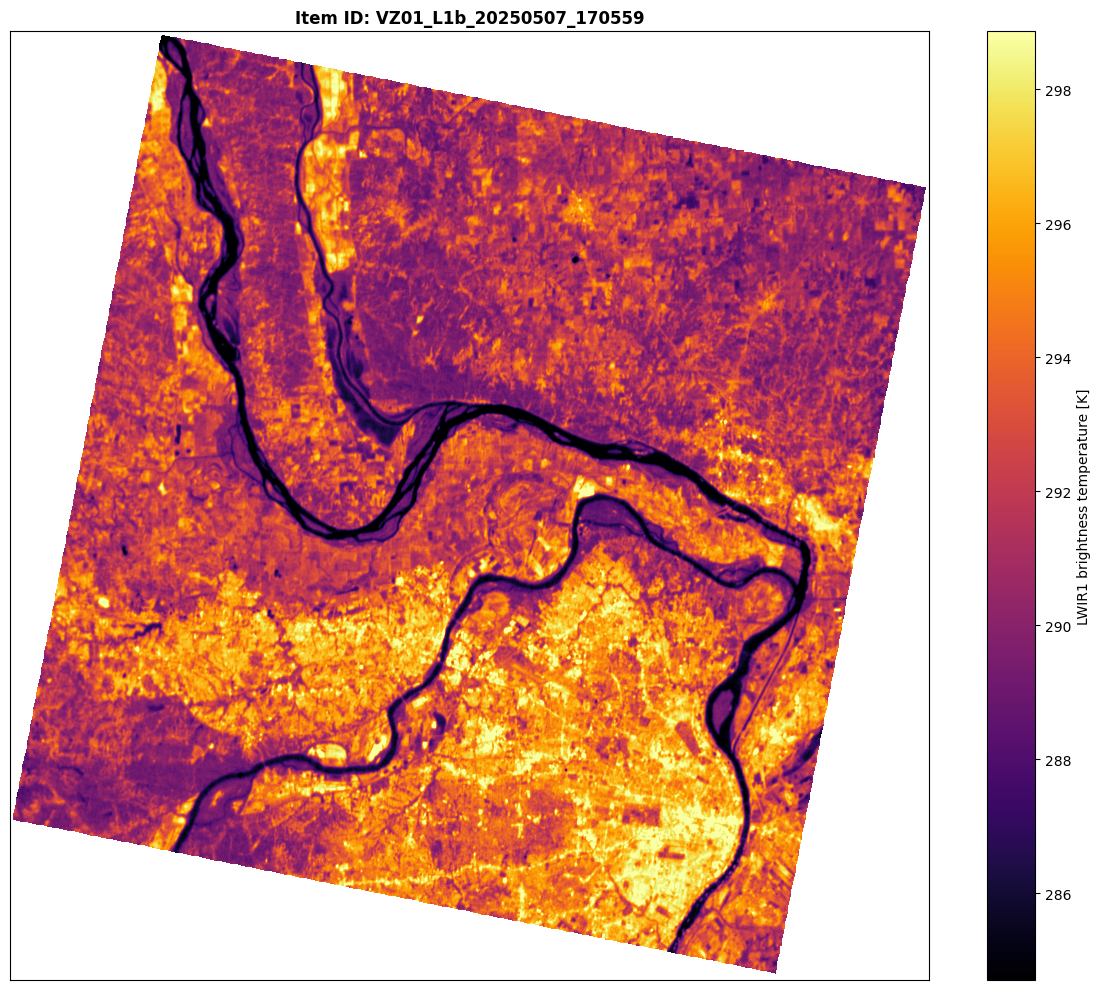

In [215]:
BT = BT.squeeze()  # Remove the extra dimension for plotting purposes
plot_image(BT, title=f'Item ID: {l1b_item.id}', cmap='inferno', colorbar_label=f'{asset} brightness temperature [K]',
           vmin=np.nanpercentile(BT, 1), vmax=np.nanpercentile(BT, 99))

## 3. Level-2 Data Products

Level-2 data products include surface reflectance and LST. Here, we'll show how to access the L2 assets, apply necessary scaling factors, and calculate some derived products.

### 3.1 Retrieving surface temperature from the L2 data

In [ ]:
collection_id = 'vz-l2'

search = catalog.search(
        collections = collection_id,
        bbox = bbox,
        datetime = datetime_range
    )

l2_items = list(search.items())
l2_items.reverse() # Oldest to newest

print(f"Found {len(l2_items)} items.")
print("Item IDs:")
for i, item in enumerate(l2_items):
    print(f"{i+1}. {item.id}")

Found 1 items.
Item IDs:
1. VZ01_L2_20250507_170559


We'll use ```rxr.open_rasterio()``` to access the LST COG.

In [217]:
l2_item = l2_items[item_idx]

# Access the LST data using rioxarray
lst = rxr.open_rasterio(l2_item.assets['LST'].href)

We'll fill pixels containing no data with NaN values and apply a scaling factor before plotting the resulting image.

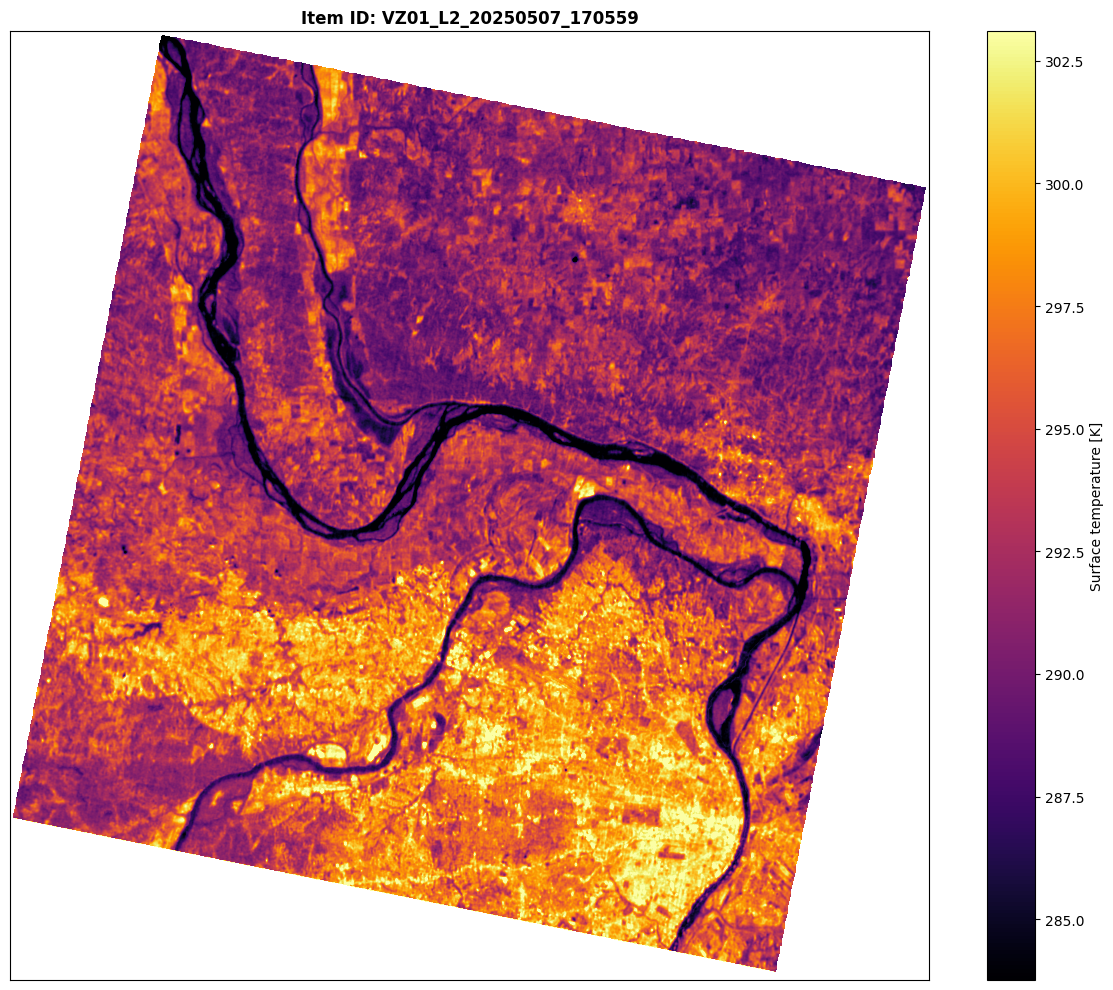

In [218]:
# Fill nodata pixels with NaN
lst = lst.where(lst>0, np.nan)

# Apply scaling factor from the metadata
lst_scaling_factor = l2_item.assets['LST'].extra_fields.get('raster:bands')[0]['scale']
lst *= lst_scaling_factor

# Plot LST image using function defined above
lst = lst.squeeze()  # Remove the extra dimension for plotting purposes
plot_image(lst, title=f'Item ID: {l2_item.id}', cmap='inferno', colorbar_label='Surface temperature [K]',
           vmin=np.nanpercentile(lst, 1), vmax=np.nanpercentile(lst, 99))

Hydrosat also provides information on LST uncertainty. Here, we'll access and plot the uncertainty data.

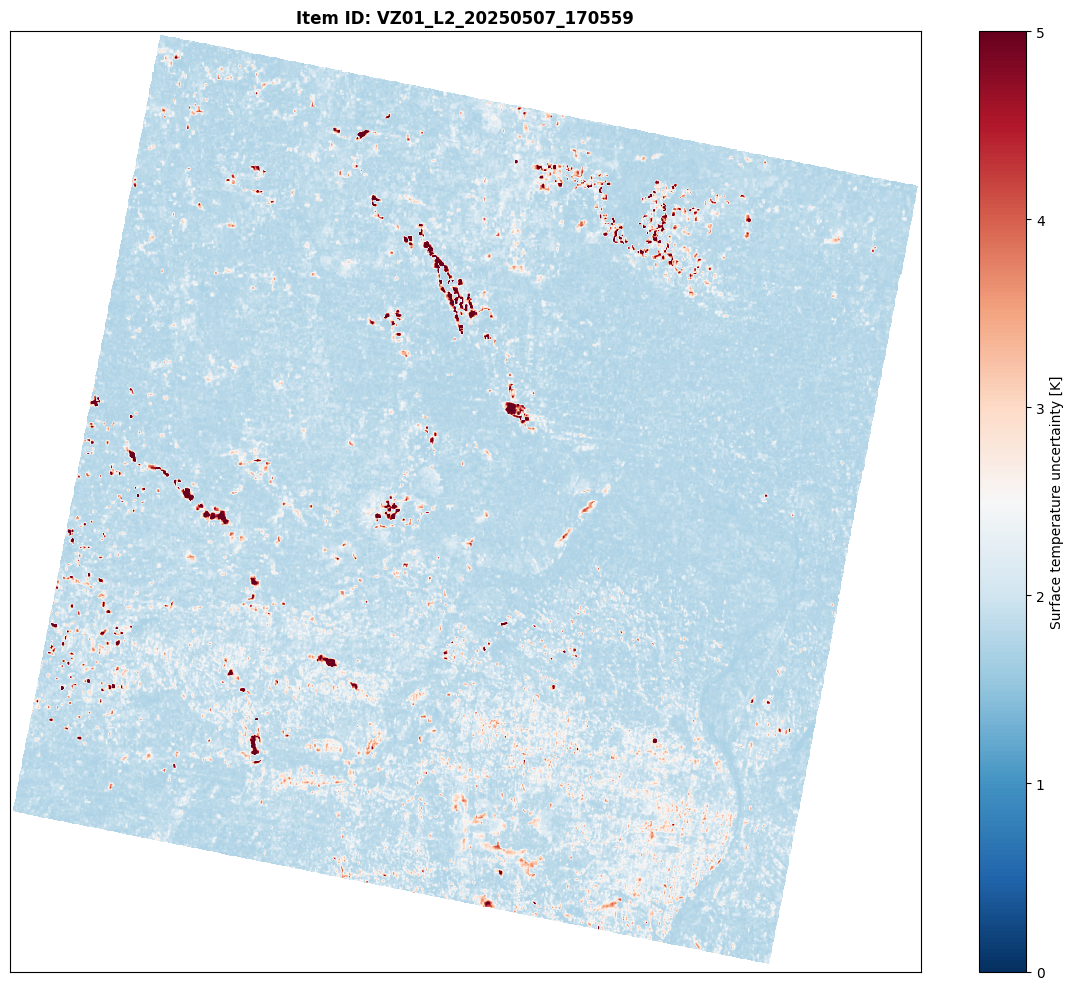

In [219]:
# Access the LST uncertainty data using rioxarray
lst_unc = rxr.open_rasterio(l2_item.assets['LST_UNCERTAINTY'].href)

# Fill nodata pixels with NaN
lst_unc = lst_unc.where(lst_unc>0, np.nan)

# Apply scaling factor
lst_unc *= lst_scaling_factor

lst_unc = lst_unc.squeeze()  # Remove the extra dimension for plotting purposes
plot_image(lst_unc, title=f'Item ID: {l2_item.id}', cmap='RdBu_r', colorbar_label='Surface temperature uncertainty [K]', vmin=0, vmax=5)

### 3.2 Calculating NDVI from the L2 data

The normalized difference vegetation index (NDVI) is a unitless value between -1 and 1 that is used as an indicator of vegetation greenness. It is calculated as:

$$
\text{NDVI} = \frac{\text{NIR} - \text{RED}}{\text{NIR} + \text{RED}}
$$

- Values closer to 1 represent healthy, green vegetation. (Healthy plants absorb more red light for photosynthesis, so the magnitude of the numerator is close to the magnitude of the denominator.)
- Values closer to 0 represent bare ground or sparse vegetation.
- Negative values tend to be associated with water or other nonvegetated surfaces.

Here, we'll walk through the process of calculating NDVI, starting by accessing NIR and red surface reflectance data.

#### 3.2.1 Retrieving data from the NIR and red bands

In [220]:
nir = rxr.open_rasterio(l2_item.assets['NIR_SR'].href)

# Change nodata pixels (nir==0) to NaN
nir = nir.where(nir > 0, np.nan)

red = rxr.open_rasterio(l2_item.assets['RED_SR'].href)

# # Change nodata pixels (red==0) to NaN
red = red.where(red > 0, np.nan)

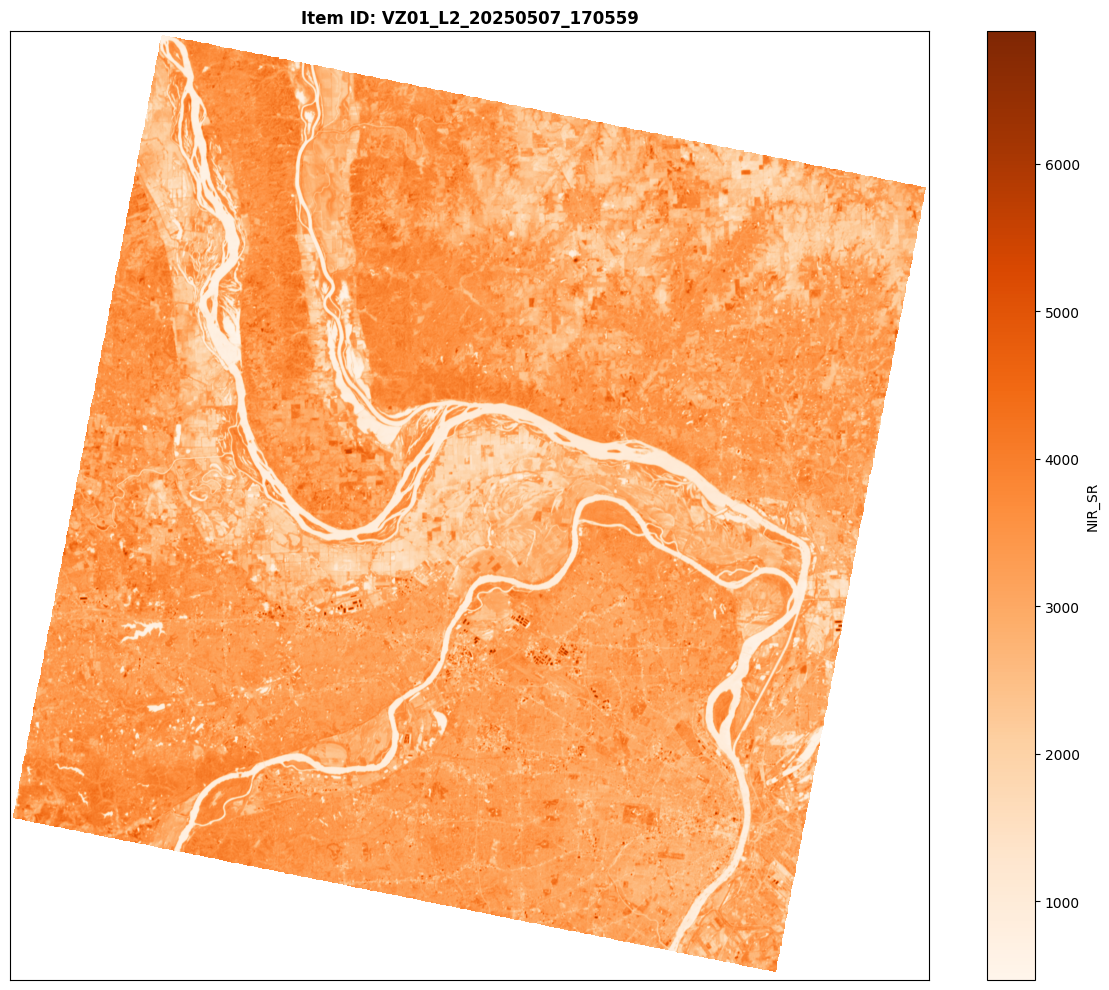

In [221]:
# Plot NIR SR
nir = nir.squeeze()  # Remove the extra dimension for plotting purposes
plot_image(nir, title=f'Item ID: {l2_item.id}', cmap='Oranges', colorbar_label='NIR_SR')

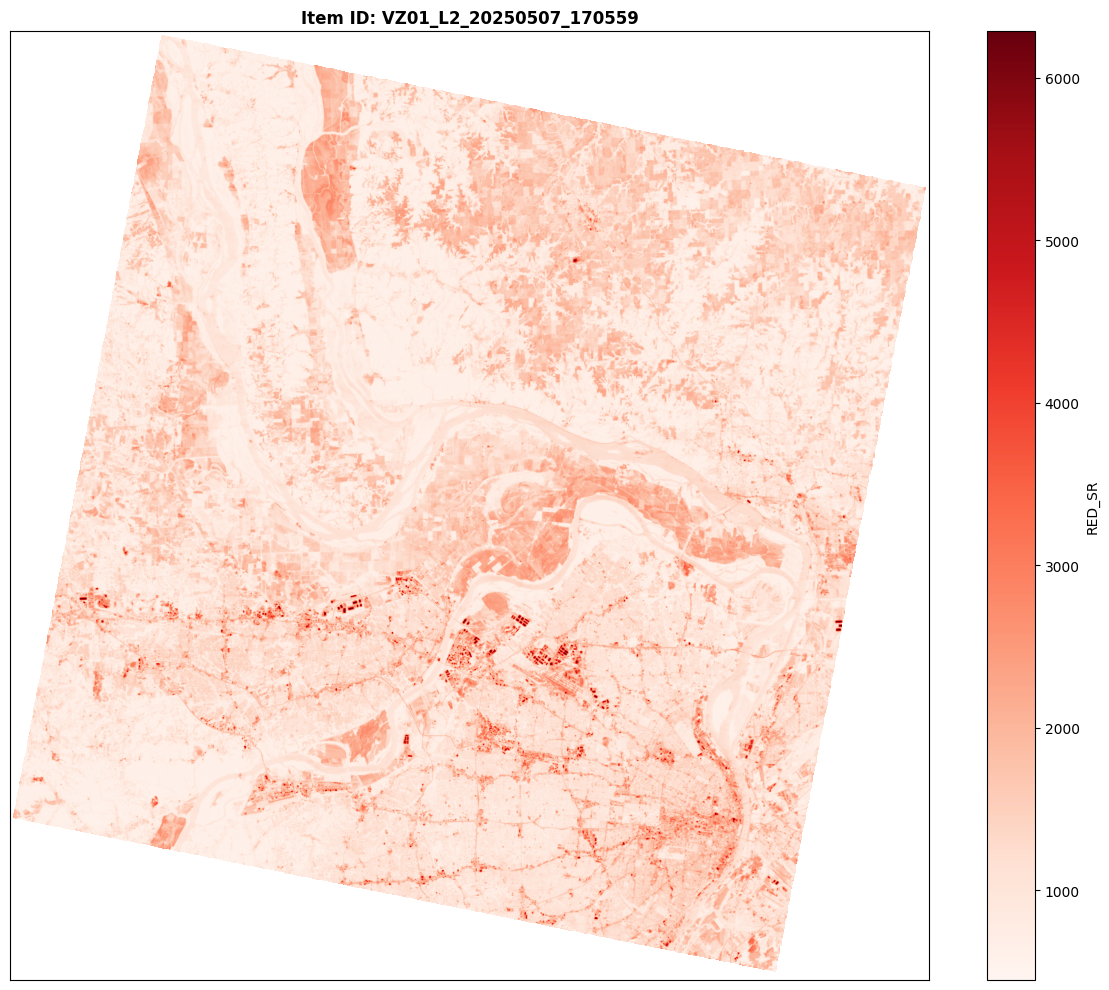

In [222]:
# Plot red SR
red = red.squeeze()  # Remove the extra dimension for plotting purposes
plot_image(red, title=f'Item ID: {l2_item.id}', colorbar_label='RED_SR')

#### 3.2.2 Calculating and visualizing NDVI

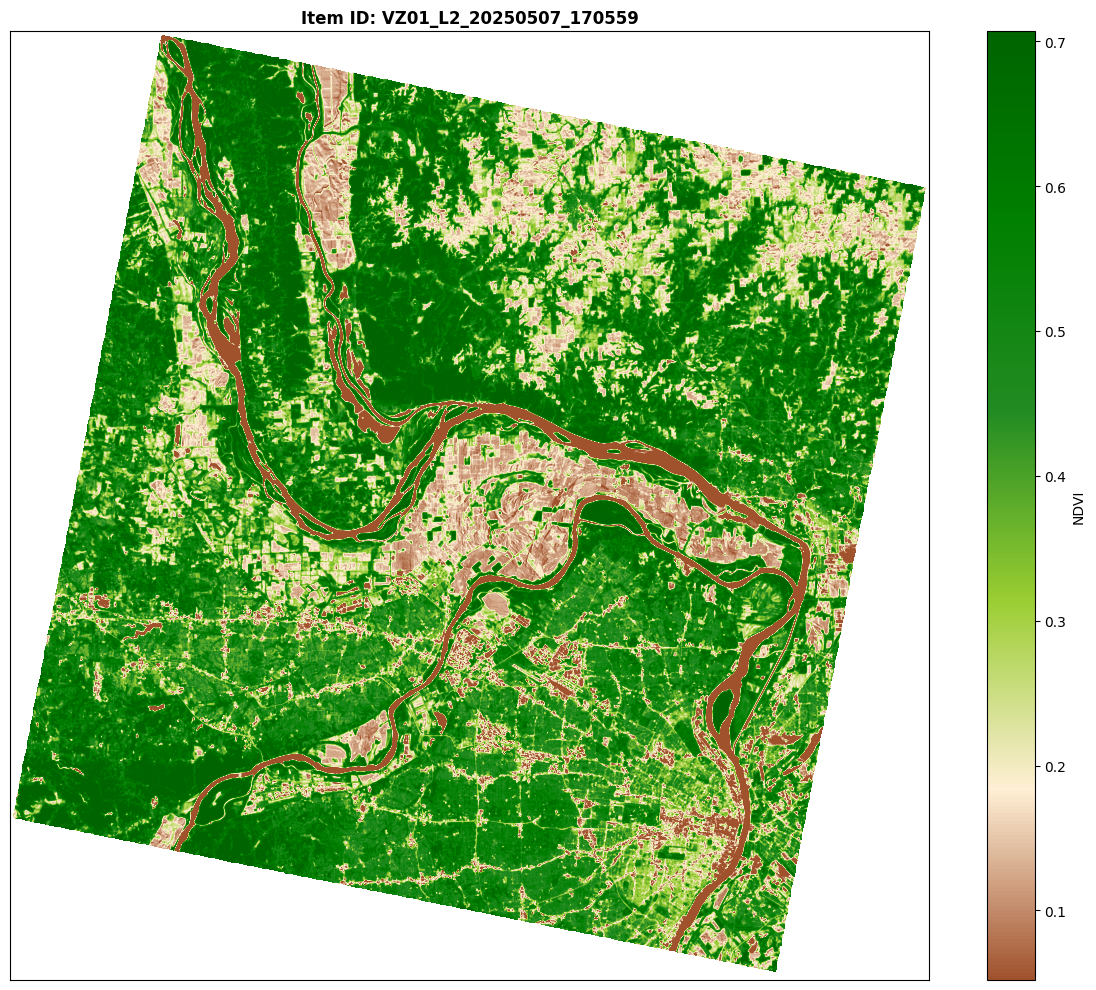

In [223]:
import matplotlib.colors as mcolors

# Calculate NDVI
ndvi = (nir - red) / (nir + red)

 # Make sure NDVI values are between -1 and 1
ndvi = ndvi.where((ndvi >= -1) & (ndvi <= 1), np.nan)

# Create custom cmap for NDVI (brown to green)
cmap = mcolors.LinearSegmentedColormap.from_list("ndvi_map", ["sienna", "papayawhip", "yellowgreen", "forestgreen", "green", "darkgreen"])

# Plot image
vmin, vmax = np.nanpercentile(ndvi, 5), np.nanpercentile(ndvi, 95)
plot_image(ndvi, title=f'Item ID: {l2_item.id}', cmap=cmap, vmin=vmin, vmax=vmax, colorbar_label='NDVI')

That's it! You've seen how to analyze and calculate some derived products from Hydrosat data.